In [1]:
import numpy as np
import h5py as h5

import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Read and prepare data

In [3]:
h5f = '/home3/ivkhar/TA/data/hadrons/bundled/mc_hadrons_qgs34_0010.h5'

In [4]:
num = 3200

with h5.File(h5f,'r') as hf:
    times_flat = hf['pr-q4-9yr/dt'][:num,:,:,4:5]*1e6 # in mks
    times_diff = hf['pr-q4-9yr/dt'][:num,:,:,5:6]*1e6 # in mks
    mask = hf['pr-q4-9yr/dt'][:num,:,:,6:7]
    real_coords = hf['pr-q4-9yr/dt'][:num,:,:,:3] # in 1.2*km
    qs = hf['pr-q4-9yr/dt'][:num,:,:,3:4]
    ev_params = hf['pr-q3-9yr/ev_params'][:num]
    
times_reg = times_flat + times_diff
mask_qs = tf.where( tf.math.logical_and(mask>0, qs>0), 1., 0. )

In [5]:
xs = tf.expand_dims( tf.linspace( 0., 5*1.2, 6 ), axis=-1 )
xs = tf.repeat(xs, 6, axis=1)
ys = tf.transpose( xs )
coords = tf.expand_dims( tf.stack( (xs,ys), axis=-1 ), axis=0 ) # in km

In [6]:
c = tf.constant(0.299792458, dtype=tf.float32) # in km\mks

### Linear approximation

In [7]:
# prepare matricies to solve
def make_matrix(coords, times_reg, mask):
    
    # matrix for dL/db
    hs = tf.ones((1,6,6,1)) # to make (x_1,x_2) -> (x_1,x_2,1), to account for b
    coords_ext = mask*tf.concat( (coords,hs), axis=-1 ) # (bs,6,6,3)
    matrix_b = tf.expand_dims( tf.math.reduce_sum( coords_ext, axis=(1,2) ), axis=-1 ) # (bs,6,6,3,1)
    times = mask*times_reg # (bs,6,6,1)
    rhs_b = tf.math.reduce_sum( times, axis=(1,2) ) # (bs,1)
    
    # matrix for dL/da
    coords_mul = tf.expand_dims( coords_ext, axis=-1) * tf.expand_dims( coords, axis=-2)
    matrix_a = tf.math.reduce_sum( coords_mul, axis=(1,2) ) # (bs,6,6,3,2)
    ts_mul = times * coords
    rhs_a = tf.math.reduce_sum( ts_mul, axis=(1,2) )
    
    matrix = tf.concat((matrix_b,matrix_a), axis=-1)
    rhs = tf.expand_dims( tf.concat((rhs_b,rhs_a), axis=-1), axis=-1 )
    
    return matrix, rhs

In [8]:
def lin_solve(matrix, rhs):
    
    sol_flat = tf.linalg.solve( matrix, rhs, adjoint=True )[:,:,0]
    print(sol_flat)
    t0 = sol_flat[:,2]
    # extract parameters
    n_z = 1/c/c - tf.math.reduce_sum(sol_flat[:,:2]*sol_flat[:,:2], axis=1)
    n_z = tf.where( n_z>0, tf.math.sqrt( n_z ), 0. ) # some configurations yield front moving faster than light
    theta_flat = tf.math.acos( n_z*c )
    phi_flat = tf.math.atan2( sol_flat[:,1], sol_flat[:,0] )
    
    return theta_flat, phi_flat, t0

In [9]:
matrix, rhs = make_matrix(coords, times_reg, mask)
# print(matrix[:10])
theta, phi, t0 = lin_solve(matrix, rhs) # (bs,)

tf.Tensor(
[[ 1.6905687  -1.694573   -1.0818247 ]
 [ 0.9904412   1.6789551  -9.411406  ]
 [-2.1926205  -1.1778897  12.180874  ]
 ...
 [-0.13772662  0.19029364  2.5974503 ]
 [-1.2350713  -0.95503634  9.593929  ]
 [-0.98233575 -0.0693085   5.815793  ]], shape=(3200, 3), dtype=float32)


#### Check

In [10]:
t0_ext = t0[:,tf.newaxis,tf.newaxis]
nx = 1/c*tf.math.sin(theta)[:,tf.newaxis,tf.newaxis] * tf.math.cos(phi)[:,tf.newaxis,tf.newaxis]
ny = 1/c*tf.math.sin(theta)[:,tf.newaxis,tf.newaxis] * tf.math.sin(phi)[:,tf.newaxis,tf.newaxis]
a = tf.concat((nx,ny), axis=-1)
a = tf.expand_dims( a, axis=1 )

t_rec = t0_ext + tf.math.reduce_sum( a*coords, axis=-1 )
t_rec = t_rec*mask[:,:,:,0]

In [11]:
diff = times_reg[:,:,:,0]*mask[:,:,:,0]-t_rec
print(tf.reduce_sum(diff, axis=(1,2)))

tf.Tensor(
[ 9.8347664e-06 -6.7949295e-06  8.5830688e-06 ...  1.0728836e-06
  2.0861626e-06  7.9870224e-06], shape=(3200,), dtype=float32)


In [12]:
t0_ext[0:10]

<tf.Tensor: shape=(10, 1, 1), dtype=float32, numpy=
array([[[-1.0818247]],

       [[-9.411406 ]],

       [[12.180874 ]],

       [[ 3.3125403]],

       [[-2.0338507]],

       [[-5.9170256]],

       [[-7.2979913]],

       [[ 7.1196465]],

       [[ 2.646719 ]],

       [[ 4.3824096]]], dtype=float32)>

### Shower core, initial

In [13]:
q_max = np.amax(qs)*1.1

In [14]:
def get_r_core_sat(qs, coords, mask, mask_qs, fill_val):
    
    qs = tf.where( mask==mask_qs, qs, [fill_val] )
    return tf.math.reduce_sum( qs*coords, axis=(1,2), keepdims=True ) / tf.math.reduce_sum(qs, axis=(1,2), keepdims=True)
      
def get_r_core(qs, coords):
    return tf.math.reduce_sum( qs*coords, axis=(1,2), keepdims=True ) / tf.math.reduce_sum(qs, axis=(1,2), keepdims=True)

In [15]:
r_core_sat = get_r_core_sat(qs, coords, mask, mask_qs, q_max) # (bs,1,1,2)
r_core = get_r_core(qs, coords)

In [16]:
print((r_core-r_core_sat)[:3,0,0,:]) # small difference since saturated detectors are near the center

tf.Tensor(
[[0.         0.        ]
 [0.27978182 0.11552715]
 [0.         0.        ]], shape=(3, 2), dtype=float32)


### S_800 reco

In [17]:
def get_eta(theta):
    
    x = theta*180.0/3.1415
    
    e1 = 3.97 - 1.79*(tf.math.abs(1.0/tf.math.cos(theta)) - 1.0)
    e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
               + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
             + 3.70692527e+00)
    res = tf.where(x<62.7,e1,e2)
    
    return res

In [18]:
Rm = tf.constant([0.09])
R1 = tf.constant([1.])

def get_profile(r, eta):

    res = tf.math.pow((r/Rm),-1.2) * tf.math.pow((1+r/Rm), -(eta-1.2)) * tf.math.pow(1.+(tf.math.pow(r,2)/R1/R1),-0.6)
    return res

In [19]:
R_x = tf.constant([[0.8]])

# r should be centered at shower's core
# normed so that ldf(800m)=1
def get_normed_ldf(r, theta):

    eta = get_eta(theta) # (batch,1,1)
    
    norm = get_profile(R_x, eta)
    ldf = get_profile(r, eta)
    
    return ldf/norm

In [20]:
s_min = tf.constant([[0.3]])
s_max = tf.constant([[1.8]])

def get_S_norm_raw(qs, coords, r_core, theta, phi, mask):
    # calculate distance to shower core
    cent_coords = coords - r_core
    proj_to_n = tf.math.sin(theta)*( tf.math.cos(phi)*cent_coords[:,:,:,0] + tf.math.sin(phi)*cent_coords[:,:,:,1] )
    dist_core = tf.math.sqrt( tf.math.reduce_sum( tf.math.pow(cent_coords,2), axis=(3) ) - tf.math.pow(proj_to_n,2) )
    # mask for distances
    mask_dist = tf.where( tf.math.logical_and(dist_core>s_min,dist_core<s_max), 1., 0. )
    mask = mask[:,:,:,0]*mask_dist
    
    mq = get_measured_ldf(mask_dist, qs)
    eq = get_expected_ldf(dist_core, theta, mask_dist)
    
    return mq, eq

def get_measured_ldf(mask, qs):

    return tf.math.reduce_sum( qs*mask, axis=(1,2) )

def get_expected_ldf(dist_core, theta, mask):
    
    exp_qs = get_normed_ldf(dist_core, theta)*mask
    
    return tf.math.reduce_sum( exp_qs, axis=(1,2) )

In [21]:
theta = theta[:,tf.newaxis, tf.newaxis]
phi = phi[:,tf.newaxis, tf.newaxis]
t0 = t0[:,tf.newaxis,tf.newaxis]

In [22]:
mq, eq = get_S_norm_raw(qs[:,:,:,0], coords, r_core, theta, phi, mask_qs)
S_norm = mq/eq

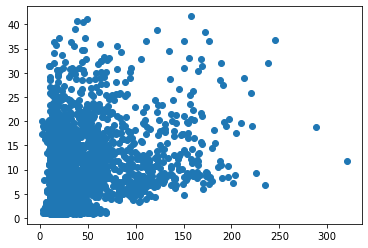

In [23]:
plt.scatter(mq,eq)
#plt.ylim((0, 500))

### Full time reco

In [24]:
def get_a_ivanov(theta, rescale):
    
    theta_degr = theta/3.1415*180.
    
    r1 = 3.3836 - 0.01848*theta_degr
    r2 = (0.6511268210e-4*(theta_degr-.2614963683))*(theta_degr*theta_degr-134.7902422*theta_degr+4558.524091)
    r3 = tf.math.exp(-3.2e-2*theta_degr + 2.0)
    
    a_ivanov = tf.where( theta_degr<25.0, r1, r2 )
    a_ivanov = tf.where( theta_degr>35.0, r3, a_ivanov )
    
    if rescale:
        a_ivanov *= 1.3
    
    return a_ivanov

def get_S_norm(dist_core, mask, qs):
    # mask for distances
    mask_dist = tf.where( tf.math.logical_and(dist_core>s_min,dist_core<s_max), 1., 0. )
    mask = mask*mask_dist
    
    mq = get_measured_ldf(mask_dist, qs)
    eq = get_expected_ldf(dist_core, theta, mask_dist)
    
    return mq/eq

In [25]:
R_L = 0.03

def get_lins_t(r, s):
    return 0.67*tf.math.pow((1 + r/R_L), 1.5)*tf.math.pow(s, -0.5)

def get_exp_time(t0, theta, phi, coords, mask, r_core, qs, rescale):
    # flat
    t_plane = t0 + tf.math.sin(theta)*( tf.math.cos(phi)*coords[:,:,:,0] + tf.math.sin(phi)*coords[:,:,:,1] ) / c
    ## curvature
    # get S_800
    cent_coords = coords - r_core
    proj_to_n = tf.math.sin(theta)*( tf.math.cos(phi)*cent_coords[:,:,:,0] + tf.math.sin(phi)*cent_coords[:,:,:,1] )
    dist_core = tf.math.sqrt( tf.math.reduce_sum( tf.math.pow(cent_coords,2), axis=(3) ) - tf.math.pow(proj_to_n,2) )
    S_norm = get_S_norm(dist_core, mask, qs)[:,tf.newaxis, tf.newaxis]
    # get curv parameters
    a_ivanov = get_a_ivanov(theta, rescale)
    aprime = a_ivanov/tf.math.sqrt(S_norm)
    s_prof = get_normed_ldf(dist_core, theta)
    # time due to curvature
    t_curv = aprime*get_lins_t( dist_core, s_prof )
    
    return (t_plane + t_curv / 1e3)*mask # 1e3 since time in mks, linsley - in ns; C ???

In [26]:
ts = get_exp_time(t0, theta, phi, coords, mask_qs[:,:,:,0], r_core_sat, qs[:,:,:,0], True)

In [27]:
print(ts[0])

tf.Tensor(
[[ 0.         0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.        -0.         0.       ]
 [ 0.         0.         0.        -2.5304592 -3.6931365 -0.       ]
 [ 0.         0.         1.1108719 -1.083818  -2.1221657  0.       ]
 [ 0.         0.         0.         1.3789799  0.         0.       ]
 [ 0.         0.         7.834401   0.         0.         0.       ]], shape=(6, 6), dtype=float32)


In [28]:
print(t_rec[0])

tf.Tensor(
[[-0.         -0.         -0.         -0.         -0.         -0.        ]
 [ 0.         -0.         -0.         -0.         -0.         -0.        ]
 [ 0.          0.         -0.         -3.1249242  -5.1584115  -0.        ]
 [ 0.          0.          0.93724644 -1.0962418  -3.1297293  -0.        ]
 [ 0.          0.          0.          0.9324404  -0.         -0.        ]
 [ 0.          0.          4.9946103   0.          0.         -0.        ]], shape=(6, 6), dtype=float32)
